In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.kernels import *
import sys

# Lambda_idx = int(sys.argv[1])
# n_external = int(sys.argv[2])
Lambda_idx = 15
n_external = 10

Lambda = Lambdas[Lambda_idx]
# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

In [2]:
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

In [3]:
from scipy.interpolate import interp1d, interp2d, LinearNDInterpolator

inner_dkparp_integral = np.load('/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/inner_dkparp_integral.npy')

In [4]:
from scipy.integrate import quad, quad_vec, trapezoid, dblquad

In [5]:
tmp_chibs = []
tmp_log_deltas = []
tmp_fnctn = []
for i in range(len(chibs)):
    for j in range(len(deltas)):
        tmp_chibs += [chibs[i]]
        tmp_log_deltas += [np.log10(deltas[j])]
        tmp_fnctn += [inner_dkparp_integral[:,i,j]]
        
f_inner_integral = LinearNDInterpolator(list(zip(tmp_chibs, tmp_log_deltas)), tmp_fnctn)

In [6]:
from tqdm import trange

In [7]:
external_chis     =  np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
print('external chi spacing', np.mean(np.diff(external_chis)))

external chi spacing 245.50420696147668


In [8]:
cross = np.zeros((100, n_external, n_external), dtype=np.float64)

In [9]:
for chi_idx in trange(n_external):
    chi = external_chis[chi_idx]
    chip = external_chis
    
    f_KLIMLo = get_f_KILo(external_chi = chip.reshape(n_external), Lambda=Lambda)

    f_KLIMLo_windowed = apply_window(f_K = f_KLIMLo,
                                     chimin = chimin,
                                     chimax = chimax)

    def f_integrand(_chib):
        _delta = np.abs(1 - chi/_chib)
        _delta = min(0.7, max(1e-6, _delta))
        integrand = 2 * f_KLIM_windowed(chi)
        integrand *= f_inner_integral((_chib, np.log10(_delta)))
        integrand /= (_chib**2)
        kernel = f_KLIMLo_windowed((2*_chib - chi))
        integrand = np.einsum('l,p->lp', integrand, kernel)
        return integrand

    ret, _ = quad_vec(f_integrand, (chimin + chi)/2, (chimax + chi)/2,
            epsabs=0.0, epsrel=1e-3,
                     workers = 1)
    cross[:,chi_idx,:] = ret


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]


In [15]:
cross = cross + np.moveaxis(cross, -1, -2) # the two cross terms are just from switching chi and chi'

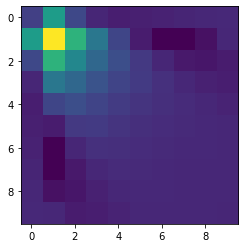

In [17]:
plt.imshow(cross[0])

In [10]:
# def compute_elem(params):
#     chi_idx, chi = params
#     chip = external_chis

#     f_KLIMLo = get_f_KILo(external_chi = chip.reshape(n_external), Lambda=Lambda)

#     f_KLIMLo_windowed = apply_window(f_K = f_KLIMLo,
#                                      chimin = chimin,
#                                      chimax = chimax)

#     def f_integrand(_chib):
#         _delta = np.abs(1 - chi/_chib)
#         _delta = min(0.7, max(1e-6, _delta))
#         integrand = 2 * f_KLIM_windowed(chi)
#         integrand *= f_inner_integral((_chib, np.log10(_delta)))
#         integrand /= (_chib**2)
#         kernel = f_KLIMLo_windowed((2*_chib - chi))
#         integrand = np.einsum('l,p->lp', integrand, kernel)
#         return integrand

#     ret, _ = quad_vec(f_integrand, (chimin + chi)/2, (chimax + chi)/2,
#             epsabs=0.0, epsrel=1e-3,
#                      workers = 32)
#     return(chi_idx, ret)

In [11]:
# params_list = []
# for chi_idx in range(n_external):
#     params = (chi_idx, external_chis[chi_idx])
#     params_list.append(params)

In [12]:
# compute_elem(params_list[0])

In [13]:
# from tqdm import tqdm
# from multiprocessing import Pool

# with Pool(processes=1) as pool:
#         results = list(tqdm(
#             pool.imap(compute_elem, params_list),
#             total=len(params_list)
#         ))